In [1]:
import os
import sys
import random
from pathlib import Path
import osgeo  #Needed for use on Windows only
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show
%matplotlib inline

In [2]:
sys.path.append(r"../src/collectcube")
from samplegen import *
from db import *

In [ ]:
## aoi_in = shapefile or geopkg with polygon objet(s) sample form
aoi_in = Path("../data/smSamp/smSampDistricts.shp")
sampsize = 500
local_db_path = '../data/smSamp/landcover.db'

## reference .tif with target crs and resolution
ref_ras = Path("../data/samp_ras.tif")

## output point shapefile
samppt_shapefile = "../data/smSamp/pts_test.shp"
## output box shapefile (boxes around pixels for reference when viewing on imagery)
sampbox_shapefile = "../data/smSamp/polys_test.shp"

res = 10

## Get random sample within polygon

aoi file has crs:epsg:8858


<Axes: >

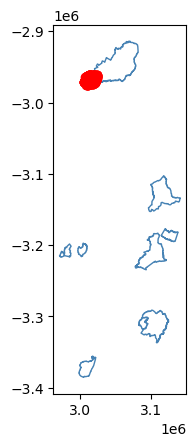

In [3]:
subpoly='D0102_Concepcion_B'

gs = get_sample_in_poly(aoi_in, sampsize, subpoly)

fig, ax = plt.subplots()
gdf = gpd.read_file(aoi_in)
gdf.plot(ax=ax, facecolor='none', edgecolor='steelblue')
gs.plot(ax=ax, color='r')

## Shift points to centroids of ref ras and make sample boxes

ref_ras has crs:EPSG:8858


<Axes: >

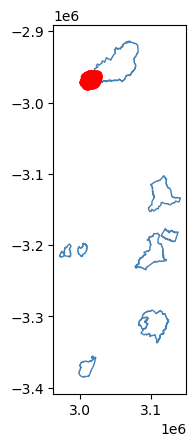

In [4]:
gs_shift = move_points_to_pixel_centroids(gs, ref_ras, write_pts=False)

## Plot again to make sure that crs is correctly matched
fig, ax = plt.subplots()
gdf = gpd.read_file(aoi_in)
if (gdf.crs != gs_shift.crs):
    print("Reprojecting aoi file to match image crs")
    gdf = gdf.to_crs(gs_shift.crs)
gdf.plot(ax=ax, facecolor='none', edgecolor='steelblue')
gs_shift.plot(ax=ax, color='r')

In [ ]:
maxpid = get_max_id_in_db(local_db_path)
print(f'current max pid is {maxpid}')

In [3]:
allpts = get_full_point_file(gs_shift, samppt_shapefile, res, lastpt=maxpid)
boxes = make_pixel_boxes_from_pts(allpts, sampbox_shapefile, res)

NameError: name 'gs_shift' is not defined

In [4]:
zoom = find_poly_on_image(1, ref_ras, boxes)

## Make pixel table and insert in landcover database

In [4]:
ptsdf = make_pixel_table(samppt_shapefile,'example'))
ptsdf.head()

,PID,Center,cent_lat,cent_long,cent_X,cent_Y,ransamp,checked,PID0,PID1
0,0000001_0,1,-22.692581,-55.655989,3168760.0,-2877060.0,1,0,1,0
1,0000002_0,1,-26.212240,-55.232312,3167140.0,-3308080.0,1,0,2,0
2,0000003_0,1,-26.454174,-55.398933,3148970.0,-3337470.0,1,0,3,0
3,0000004_0,1,-25.230882,-56.398586,3072420.0,-3188540.0,1,0,4,0
4,0000005_0,1,-24.552260,-56.964313,3028280.0,-3105580.0,1,0,5,0


In [5]:
treat_existing = 'append' # 'replace' | 'append' | 'fail'
make_pixel_table_in_db(ptsdf, local_db_path, treat_existing)
table_check = check_table(local_db_path,'pixels')

In [7]:
## Check that primary key was made
meta = sa.MetaData()
table = sa.Table('pixels', meta, autoload_with=engine)
primaryKeyColNames = [pk_column.name for pk_column in table.primary_key.columns.values()]
print('Primary Key is {}'.format(primaryKeyColNames))

Primary Key is ['PID']
